# Import librairies

In [284]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# lazy 
from lazypredict.Supervised import LazyClassifier
from sklearn.utils import all_estimators
from sklearn.base import ClassifierMixin

# search hyperparameters
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV

# modèles 
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier 
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedRandomForestClassifier, BalancedBaggingClassifier

import xgboost as xgb
import shap

# métriques 
from imblearn.metrics import classification_report_imbalanced, geometric_mean_score
from sklearn.metrics import classification_report,accuracy_score, f1_score, confusion_matrix, precision_score

# Rééchantillonage
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler


# Chargement données issues du preprocessing

In [249]:

# jeu de données issues du preprocessing mixte
df_V1 = pd.read_csv("../data_saved/df_final.csv", index_col=["id_Location","id_Date"])

# jeu de données issues du preprocessing successif
df_V2 =  pd.read_csv("../data_saved/data_preprocessed_V2.csv", index_col=["id_Location","id_Date"])
df_V2 = df_V2.drop(columns=["Evaporation", 'Sunshine', 'Cloud9am', 'Cloud3pm'])

# jeu de données issues du preprocessing successif pour Canberra
df_Canberra =  pd.read_csv("../src/data_location_V2/df_Canberra.csv", index_col=["id_Location","id_Date"])

print(df_V1.shape)
print(df_V1.columns)
print(df_V2.shape)
print(df_V2.columns)
print(df_Canberra.shape)
print(df_Canberra.columns)

(135600, 42)
Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm', 'RainToday',
       'RainTomorrow', 'WindGustDir_cos', 'WindGustDir_sin', 'WindDir9am_cos',
       'WindDir9am_sin', 'WindDir3pm_cos', 'WindDir3pm_sin', 'Month_cos',
       'Month_sin', 'Season_cos', 'Season_sin', 'Climate_Desert',
       'Climate_Grassland', 'Climate_Subtropical', 'Climate_Temperate',
       'Climate_Tropical', 'Year_2007', 'Year_2008', 'Year_2009', 'Year_2010',
       'Year_2011', 'Year_2012', 'Year_2013', 'Year_2014', 'Year_2015',
       'Year_2016', 'Year_2017'],
      dtype='object')
(142193, 46)
Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm', 'RainToday',
       'RainTomorrow', 'sin_lat', 'cos

In [250]:
print(df_V1.dropna().shape)
print(df_V2.dropna().shape)

(135600, 42)
(136222, 46)


# Séparation en train et test 

In [251]:
# function pour l'intégrer dans un pipeline et pouvoir l'utiliser sur des données par location

def separation_train_test(df, sep_method = "classique", col_target = "RainTomorrow"):
    # drop les Nas restants 
    df = df.dropna()
    target = df[col_target]
    feats = df.drop(columns = col_target)

    if sep_method == "classique":
        X_train, X_test, y_train, y_test = train_test_split(feats, target, test_size=0.3, random_state=1234, stratify=target)
    if sep_method == "temporelle":
        df["Date"] = df.index.get_level_values(1).values
        years = pd.to_datetime(df.Date).dt.year
        years.unique()
        years.value_counts(ascending=True)
        Part_data_year = years.value_counts().sort_index().cumsum()/len(years)
        print("Part des données par années ", Part_data_year)
        year_split = Part_data_year.loc[Part_data_year > 0.8].index[0]
        id_train = years[years < year_split].index
        id_test = years[years >= year_split].index
        print("Séparation des données avant et après ", year_split)
        X_train = feats.loc[id_train]
        X_test =  feats.loc[id_test]
        y_train = target.loc[id_train]
        y_test =  target.loc[id_test]

    if 'Date' in X_train.columns:
        X_train = X_train.drop(columns = "Date")
        X_test = X_test.drop(columns = "Date")
    if 'Location' in X_train.columns:
        X_train = X_train.drop(columns = 'Location')
        X_test = X_test.drop(columns = 'Location')

    return X_train, X_test, y_train, y_test

In [252]:
X_train_V2, X_test_V2, y_train_V2, y_test_V2 = separation_train_test(df_V2, sep_method="classique")
X_train_V1, X_test_V1, y_train_V1, y_test_V1 = separation_train_test(df_V1, sep_method="classique")

In [253]:
X_train_V2t, X_test_V2t, y_train_V2t, y_test_V2t = separation_train_test(df_V2, sep_method="temporelle")
X_train_V1t, X_test_V1t, y_train_V1t, y_test_V1t = separation_train_test(df_V1, sep_method="temporelle")

Part des données par années  Date
2007   0.00
2008   0.02
2009   0.13
2010   0.25
2011   0.35
2012   0.46
2013   0.57
2014   0.70
2015   0.82
2016   0.94
2017   1.00
Name: count, dtype: float64
Séparation des données avant et après  2015
Part des données par années  Date
2007   0.00
2008   0.02
2009   0.13
2010   0.25
2011   0.35
2012   0.46
2013   0.57
2014   0.70
2015   0.82
2016   0.94
2017   1.00
Name: count, dtype: float64
Séparation des données avant et après  2015


In [254]:
print(X_train_V1t.shape)
print(X_test_V1t.shape)
print(X_train_V2t.shape)
print(X_test_V2t.shape)

(94452, 39)
(41148, 39)
(94809, 43)
(41413, 43)


# Scaling

In [255]:
# fonction pour scaler, avec chois du scaler

def scaling(X_train, X_test, scaler = MinMaxScaler()):

    scaler = scaler
    # On fit sur Xtrain complet
    scaler = MinMaxScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns = X_train.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns = X_test.columns)
    
    return X_train_scaled, X_test_scaled


In [256]:
X_train_V1t_scaled, X_test_V1t_scaled = scaling(X_train_V1t, X_test_V1t, scaler = MinMaxScaler())
X_train_V2t_scaled, X_test_V2t_scaled = scaling(X_train_V2t, X_test_V2t, scaler = MinMaxScaler())

<Figure size 1000x1000 with 0 Axes>

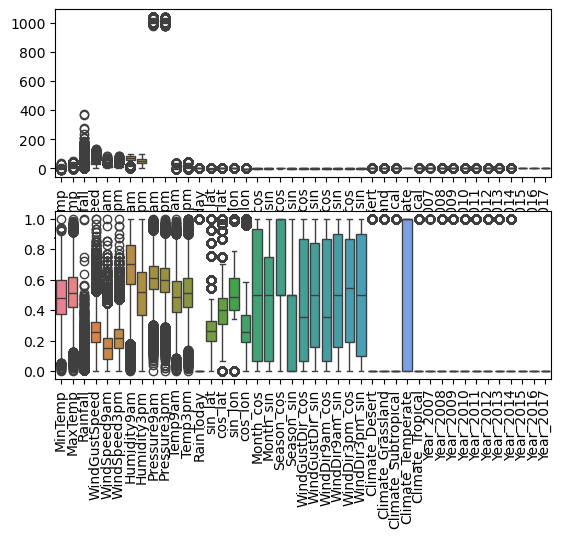

In [257]:
plt.figure(figsize = (10,10))
plt.subplots(ncols=1, nrows=2)
plt.subplot(211)
sns.boxplot(X_train_V2t)
plt.xticks(rotation=90)
plt.subplot(212)
sns.boxplot(X_train_V2t_scaled)
plt.xticks(rotation=90)
plt.show()

# Lazy predict 

In [258]:

removed_classifiers = [
"ClassifierChain",
"ComplementNB",
"GradientBoostingClassifier",
"GaussianProcessClassifier",
"HistGradientBoostingClassifier",
"MLPClassifier",
"LogisticRegressionCV",
"MultiOutputClassifier",
"MultinomialNB",
"OneVsOneClassifier",
"OneVsRestClassifier",
"OutputCodeClassifier",
"RadiusNeighborsClassifier",
"VotingClassifier",
'SVC','LabelPropagation','LabelSpreading','NuSV']

def lazy_results(X_train, X_test, y_train, y_test, removed_classifiers=removed_classifiers):
    classifiers_list = [est for est in all_estimators() if (issubclass(est[1], ClassifierMixin) and (est[0] not in removed_classifiers))]
    # création classifier lazy 
    clf_lazy = LazyClassifier(
        verbose=0, classifiers= classifiers_list,
        ignore_warnings=True, 
        custom_metric=None)

    # fits
    models, predictions = clf_lazy.fit(X_train, X_test, y_train, y_test)
    # sort par f1 score 
    models= models.sort_values("F1 Score", ascending = False)
    models = models.apply(lambda x: round(x, ndigits=2))
    # print models 
    display(models)
    return models, predictions



In [259]:

models_V2t, predictions_V2t = lazy_results(X_train_V2t_scaled, X_test_V2t_scaled, y_train_V2t, y_test_V2t)
models_V1t, predictions_V1t = lazy_results(X_train_V1t_scaled, X_test_V1t_scaled, y_train_V1t, y_test_V1t)

models_V1t.to_csv("../modeling_results/lazy_predict_mixtepreprocessing_temp.csv",  decimal = ",")
models_V2t.to_csv("../modeling_results/lazy_predict_succereprocessing_temp.csv",  decimal = ",")




'tuple' object has no attribute '__name__'
Invalid Classifier(s)


100%|██████████| 26/26 [00:55<00:00,  2.13s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
RandomForestClassifier,0.85,0.72,0.72,0.84,16.10
ExtraTreesClassifier,0.85,0.71,0.71,0.84,10.26
LogisticRegression,0.84,0.71,0.71,0.83,0.34
LinearDiscriminantAnalysis,0.84,0.72,0.72,0.83,0.56
BaggingClassifier,0.84,0.71,0.71,0.83,10.04
CalibratedClassifierCV,0.84,0.71,0.71,0.83,3.82
LinearSVC,0.84,0.71,0.71,0.83,0.85
AdaBoostClassifier,0.84,0.71,0.71,0.83,5.40
SGDClassifier,0.84,0.70,0.70,0.83,0.55


'tuple' object has no attribute '__name__'
Invalid Classifier(s)


100%|██████████| 26/26 [00:50<00:00,  1.95s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
RandomForestClassifier,0.85,0.72,0.72,0.84,15.08
ExtraTreesClassifier,0.85,0.71,0.71,0.84,10.63
LinearDiscriminantAnalysis,0.84,0.72,0.72,0.83,0.42
LogisticRegression,0.84,0.72,0.72,0.83,0.30
CalibratedClassifierCV,0.84,0.71,0.71,0.83,2.67
BaggingClassifier,0.84,0.71,0.71,0.83,8.33
LinearSVC,0.84,0.71,0.71,0.83,0.67
AdaBoostClassifier,0.84,0.71,0.71,0.83,4.69
SGDClassifier,0.84,0.71,0.71,0.83,0.42


# modèles simples 

In [269]:
# Choix de 3 modèles 
models_select  = {
    'LogisticRegression': LogisticRegression(max_iter = 500, n_jobs=-1),
    'RandomForestClassifier': RandomForestClassifier(n_jobs=-1),
    'BaggingClassifier': BaggingClassifier(n_estimators = 500, max_samples = 0.5, max_features = 0.5, n_jobs=-1)
}


def fit_models(models_select, X_train,X_test, y_train, y_test, 
               unbalanced = False, dir_name=''): 
      # Dictionnaire pour stocker les résultats
      results = {}
      cm = {}
      fitted_models = {}
      for model_name, model in models_select.items():
            print("Fitting " , model_name)
            model.fit(X_train, y_train)

            # Tester sur les données de test
            y_pred = model.predict(X_test)

            # métriques
            test_accuracy = accuracy_score(y_test, y_pred)
            test_f1_score = f1_score(y_test, y_pred)
            report = classification_report(y_test, y_pred, output_dict=True)
            
            if unbalanced == True :
                 report = classification_report_imbalanced(y_test, y_pred, output_dict=True)
            
            report = pd.DataFrame(report).transpose()
            # Stocker les résultats
            results[model_name] = report
            cm[model_name] = confusion_matrix(y_test, y_pred)
            cm[model_name] = pd.DataFrame(cm[model_name], index = y_train.unique(), columns=y_train.unique())    
            
            fitted_models[model_name] = model
      return results, cm, fitted_models

def print_save_models(models_select, report,  cm,  save_name):
    # affiche et save les résultats
    for model_name, model in models_select.items():
        print("\n")
        print("Nom du modèle :",model_name)
        print("Rapport de classification :")
        print(report[model_name])
        print("Matrice de confusion :")
        print(cm[model_name])
        report[model_name] = report[model_name].apply(lambda x: round(x,ndigits=2))
        report[model_name].to_csv("../modeling_results/" + dir_name + "results_" + save_name + "_" + model_name + ".csv", decimal =",")




In [270]:
# Test sur données preprocessed V1

report_V1t, cm_V1t, models_V1t = \
    fit_models(models_select, X_train_V1t_scaled, X_test_V1t_scaled, y_train_V1t, y_test_V1t)

print_save_models(models_select, report_V1t, cm_V1t, save_name="base_V1t")



Fitting  LogisticRegression
Fitting  RandomForestClassifier
Fitting  BaggingClassifier


Nom du modèle : LogisticRegression
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.89    0.90      0.89 32167.00
1.0                0.63    0.61      0.62  8981.00
accuracy           0.84    0.84      0.84     0.84
macro avg          0.76    0.75      0.76 41148.00
weighted avg       0.83    0.84      0.83 41148.00
Matrice de confusion :
       0.00  1.00
0.00  28878  3289
1.00   3490  5491


Nom du modèle : RandomForestClassifier
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.87    0.96      0.91 32167.00
1.0                0.75    0.49      0.59  8981.00
accuracy           0.85    0.85      0.85     0.85
macro avg          0.81    0.72      0.75 41148.00
weighted avg       0.84    0.85      0.84 41148.00
Matrice de confusion :
       0.00  1.00
0.00  30722  1445
1.00   4619  4362


Nom du modè

In [272]:
# Test sur données preprocessed V2

report_V2t, cm_V2t, models_V2t = \
    fit_models(models_select, X_train_V2t_scaled, X_test_V2t_scaled, y_train_V2t, y_test_V2t)

print_save_models(models_select, report_V2t, cm_V2t , save_name="base_V2t")



Fitting  LogisticRegression
Fitting  RandomForestClassifier
Fitting  BaggingClassifier


Nom du modèle : LogisticRegression
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.89    0.90      0.89 32235.00
1.0                0.63    0.62      0.62  9178.00
accuracy           0.83    0.83      0.83     0.83
macro avg          0.76    0.76      0.76 41413.00
weighted avg       0.83    0.83      0.83 41413.00
Matrice de confusion :
       0.00  1.00
0.00  28891  3344
1.00   3497  5681


Nom du modèle : RandomForestClassifier
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.87    0.96      0.91 32235.00
1.0                0.77    0.49      0.60  9178.00
accuracy           0.85    0.85      0.85     0.85
macro avg          0.82    0.72      0.75 41413.00
weighted avg       0.85    0.85      0.84 41413.00
Matrice de confusion :
       0.00  1.00
0.00  30895  1340
1.00   4722  4456


Nom du modè

# Rééchantillonage

In [278]:

def resample(X_train, y_train, resampler = SMOTE()):
    
    print('Classes échantillon initial :', dict(pd.Series(y_train).value_counts()))
    resampler = resampler
    X_sm, y_sm = resampler.fit_resample(X_train, y_train)
    print('Classes échantillon SMOTE :', dict(pd.Series(y_sm.value_counts())))
    return X_sm, y_sm

In [279]:
# oversampling et fit sur données preprocessed V2
X_train_rs_V2t, y_train_rs_V2t = resample(X_train_V2t_scaled,  y_train_V2t, resampler = SMOTE())

report_V2t, cm_V2t, models_V2t = \
    fit_models(models_select, X_train_rs_V2t, X_test_V2t_scaled, y_train_rs_V2t, y_test_V2t)

print_save_models(models_select, report_V2t, cm_V2t , save_name="rssmote_V2t")


Classes échantillon initial : {0.0: 73484, 1.0: 21325}
Classes échantillon SMOTE : {0.0: 73484, 1.0: 73484}
Fitting  LogisticRegression
Fitting  RandomForestClassifier
Fitting  BaggingClassifier


Nom du modèle : LogisticRegression
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.94    0.70      0.80 32235.00
1.0                0.44    0.84      0.58  9178.00
accuracy           0.73    0.73      0.73     0.73
macro avg          0.69    0.77      0.69 41413.00
weighted avg       0.83    0.73      0.75 41413.00
Matrice de confusion :
       0.00  1.00
0.00  22477  9758
1.00   1512  7666


Nom du modèle : RandomForestClassifier
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.89    0.91      0.90 32235.00
1.0                0.66    0.62      0.64  9178.00
accuracy           0.85    0.85      0.85     0.85
macro avg          0.78    0.76      0.77 41413.00
weighted avg       0.84    0.85  

In [281]:
# undersampling et fit sur données preprocessed V2
X_train_rs_V2t, y_train_rs_V2t = resample(X_train_V2t_scaled,  y_train_V2t, resampler = RandomUnderSampler())

report_V2t, cm_V2t, models_V2t = \
    fit_models(models_select, X_train_rs_V2t, X_test_V2t_scaled, y_train_rs_V2t, y_test_V2t)

print_save_models(models_select, report_V2t, cm_V2t , save_name="rsunder_V2t")


Classes échantillon initial : {0.0: 73484, 1.0: 21325}
Classes échantillon SMOTE : {0.0: 21325, 1.0: 21325}
Fitting  LogisticRegression
Fitting  RandomForestClassifier
Fitting  BaggingClassifier


Nom du modèle : LogisticRegression
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.93    0.71      0.81 32235.00
1.0                0.45    0.83      0.58  9178.00
accuracy           0.73    0.73      0.73     0.73
macro avg          0.69    0.77      0.69 41413.00
weighted avg       0.83    0.73      0.76 41413.00
Matrice de confusion :
       0.00  1.00
0.00  22833  9402
1.00   1590  7588


Nom du modèle : RandomForestClassifier
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.92    0.82      0.87 32235.00
1.0                0.55    0.76      0.64  9178.00
accuracy           0.81    0.81      0.81     0.81
macro avg          0.73    0.79      0.75 41413.00
weighted avg       0.84    0.81  

In [285]:
# test Balanced RandomForest et Bagging sur V2t

models_select_balanced = {
    'BalancedRandomForestClassifier': BalancedRandomForestClassifier(n_jobs=-1),
    'BalancedBaggingClassifier': BalancedBaggingClassifier(n_estimators = 500, max_samples = 0.5, max_features = 0.5, n_jobs=-1)
}

report_V2t, cm_V2t, models_V2t = \
    fit_models(models_select_balanced, X_train_rs_V2t, X_test_V2t_scaled, y_train_rs_V2t, y_test_V2t)

print_save_models(models_select_balanced, report_V2t, cm_V2t , save_name="balanced_V2t")


Fitting  BalancedRandomForestClassifier
Fitting  BalancedBaggingClassifier


Nom du modèle : BalancedRandomForestClassifier
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.92    0.82      0.87 32235.00
1.0                0.55    0.77      0.64  9178.00
accuracy           0.81    0.81      0.81     0.81
macro avg          0.74    0.79      0.75 41413.00
weighted avg       0.84    0.81      0.82 41413.00
Matrice de confusion :
       0.00  1.00
0.00  26397  5838
1.00   2154  7024


Nom du modèle : BalancedBaggingClassifier
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.92    0.81      0.86 32235.00
1.0                0.53    0.76      0.63  9178.00
accuracy           0.80    0.80      0.80     0.80
macro avg          0.73    0.79      0.75 41413.00
weighted avg       0.84    0.80      0.81 41413.00
Matrice de confusion :
       0.00  1.00
0.00  26124  6111
1.00   2180  6998


# Optimisation des hyperparamètres

In [302]:
# Dictionnaire pour stocker les résultats (njobs -1)
results_search = {}

def compare_search_methods(model_name, 
                           model, 
                           param_grid, 
                           X_train,  X_test, y_train, y_test):
    # search_methods = {
    #     'GridSearchCV': GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1),
    #     'RandomizedSearchCV': RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=5, cv=5, scoring='accuracy', random_state=42, n_jobs=-1),
    #     'BayesSearchCV': BayesSearchCV(estimator=model, search_spaces=param_grid, n_iter=5, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)
    # }
    
    search_methods = {
        'GridSearchCV': GridSearchCV(estimator=model, 
                                     param_grid=param_grid, 
                                     cv=5, scoring='precision',
                                     verbose =),
    }

    results_search[model_name] = {}
    i =1
    print(model_name)
    for search_name, search in search_methods.items():
        print(search_name)
        # Effectuer la recherche d'hyperparamètres
        search.fit(X_train, y_train)
        
        # Meilleur score et hyperparamètres trouvés
        best_params = search.best_params_
        best_score = search.best_score_
        
        # Tester sur les données de test
        y_pred = search.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_pred)
        test_f1_score = f1_score(y_test, y_pred)
        test_precision = precision_score(y_test, y_pred)

        # Stocker les résultats
        results_search[model_name][search_name] = {
            'best_params': best_params,
            'best_cv_score': best_score,
            'test_accuracy': test_accuracy,
            'test_f1_score': test_f1_score,
            'test_precision' : test_precision
        }
return results_search


In [304]:
# Hyperparamètres à tester pour chaque modèle
param_grids = {
    'LogisticRegression': {
                           'C': [0.01, 0.1, 1, 10], 
                           'solver': ['liblinear', 'lbfgs']},
    'RandomForestClassifier': {'n_estimators': [50, 100, 200], 
                               'max_depth': [10, 20, 30]},
     'BaggingClassifier': {'n_estimators': [500, 1000, 2000], 
                           'max_samples' : [0.05, 0.1, 0.2, 0.5]}
}
# Hyperparamètres à tester pour chaque modèle
param_grids2 = {
    'LogisticRegression': {
        'max_iter' : [100,500],
        'C':[0.001, 0.01, 0.1, 1, 10, 100],
        'solver': ['newton-cholesky','newton-cg','lbfgs', 'liblinear', 'sag', 'saga'],
        'penalty':['none', 'elasticnet', 'l1', 'l2'],
        'fit_intercept': [True, False]},
    'RandomForestClassifier': {
        'n_estimators': [100, 200],
        'criterion': ['gini', 'entropy', 'log_loss'], 
        'max_depth': [10, 30, 50],
        'max_features': ['sqrt', 'log2', None],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10]},
    'BaggingClassifier': {
        'n_estimators': [50, 500, 1000, 2000], 
        'max_samples' : [0.05, 0.1, 0.2, 0.5, 1],
        'max_features': [0.5, 0.8, 0.95, 1.0],
        'bootstrap': [True, False],
        'bootstrap_features': [True, False],
        'oob_score': [True, False]}
}

In [291]:
models_select

{'LogisticRegression': LogisticRegression(max_iter=500, n_jobs=-1),
 'RandomForestClassifier': RandomForestClassifier(n_jobs=-1),
 'BaggingClassifier': BaggingClassifier(max_features=0.5, max_samples=0.5, n_estimators=500,
                   n_jobs=-1)}

In [ ]:

model_name = 'LogisticRegression'
model = LogisticRegression(max_iter=500, n_jobs=-1)
# undersampling et fit sur données preprocessed V2
X_train_rs_V2t, y_train_rs_V2t = resample(X_train_V2t_scaled,  y_train_V2t, resampler = RandomUnderSampler())

results_search = compare_search_methods(model_name, model, 
                       param_grids2[model_name],  
                       X_train_rs_V2t, X_test_V2t_scaled,
                       y_train_rs_V2t,  y_test_V2t)




Classes échantillon initial : {0.0: 73484, 1.0: 21325}
Classes échantillon SMOTE : {0.0: 21325, 1.0: 21325}
LogisticRegression
GridSearchCV
Fitting 5 folds for each of 576 candidates, totalling 2880 fits


# Modèle par location

In [ ]:

# model par location
select_location = "Canberra"
# df_location = list()

df_location =  pd.read_csv("../src/data_location_V2/df_" + select_location + ".csv", index_col=["id_Location","id_Date"])
print(df_location.shape)
print(df_location.columns)

X_train, X_test, y_train, y_test = \
    separation_train_test(df_location, 
                          sep_method = "temporelle", 
                          col_target = "RainTomorrow")


X_train_scaled, X_test_scaled = scaling(X_train, X_test, scaler = MinMaxScaler())

models_lazy, predictions_lazy = lazy_results(X_train_scaled, X_test_scaled, y_train, y_test)


report_location, cm_location, models_location = \
    fit_models(models_select, X_train_scaled, X_test_scaled, y_train, y_test)

print_save_models(models_select, report_V2t, cm_V2t , save_name="base_"+ select_location)




(2601, 38)
Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow', 'Month_cos', 'Month_sin',
       'Season_cos', 'Season_sin', 'WindGustDir_cos', 'WindGustDir_sin',
       'WindDir9am_cos', 'WindDir9am_sin', 'WindDir3pm_cos', 'WindDir3pm_sin',
       'Year_2007', 'Year_2008', 'Year_2009', 'Year_2010', 'Year_2011',
       'Year_2012', 'Year_2013', 'Year_2014', 'Year_2015', 'Year_2016',
       'Year_2017'],
      dtype='object')
Part des données par années  Date
2007   0.02
2008   0.16
2009   0.26
2010   0.38
2011   0.50
2012   0.62
2013   0.71
2014   0.79
2015   0.87
2016   0.96
2017   1.00
Name: count, dtype: float64
Séparation des données avant et après  2015
'tuple' object has no attribute '__name__'
Invalid Classifier(s)


100%|██████████| 26/26 [00:01<00:00, 17.14it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LinearSVC,0.81,0.73,0.73,0.80,0.02
RandomForestClassifier,0.81,0.73,0.73,0.79,0.36
LogisticRegression,0.80,0.72,0.72,0.79,0.02
ExtraTreesClassifier,0.80,0.71,0.71,0.78,0.23
BaggingClassifier,0.80,0.72,0.72,0.78,0.16
AdaBoostClassifier,0.79,0.72,0.72,0.78,0.17
LinearDiscriminantAnalysis,0.80,0.71,0.71,0.78,0.19
SGDClassifier,0.78,0.75,0.75,0.78,0.02
RidgeClassifier,0.79,0.69,0.69,0.77,0.01
